# Bank Customer Segmentation

In this kernel I will perform segmentation of German bank customers. The first step is to read necessary libraries. We will use: 
* [pandas](https://pandas.pydata.org/) - to manipulate data frames
* [numpy](http://www.numpy.org/) - providing linear algebra
* [seaborm](https://seaborn.pydata.org/) - to create nice visualizations
* [matplotlib](https://matplotlib.org/) - basic tools for visualizations
* [scikit-learn](https://scikit-learn.org/stable/) - machine learning library


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Reading the raw data 

In [3]:
data = pd.read_csv("german_credit_data.csv")
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


It looks that the first column is simply an index so we delete it.

In [4]:
data.drop(data.columns[0], inplace=True, axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [5]:
print("The dataset has", data.shape[0], "number of observations (customers) and", data.shape[1], "number of columns (attritubes)")

The dataset has 1000 number of observations (customers) and 9 number of columns (attritubes)


Checking for missing values.

In [6]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent (%)'])
    return missing_values

In [7]:
missing (data)

,Missing_Number,Missing_Percent (%)
Checking account,394,39.4
Saving accounts,183,18.3
Age,0,0.0
Sex,0,0.0
Job,0,0.0
Housing,0,0.0
Credit amount,0,0.0
Duration,0,0.0
Purpose,0,0.0


Only columns: Checking account and Savings account had missing values.

In [8]:
print("Columns data types:\n{}".format(data.dtypes))

Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


There are 3 numeric variables and 5 categorical ones.

Let's check how many, and what are the possible (unique) values in each categorical column.

In [9]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## Exploratory Data Analysis.

**Scatter plot of the three numerical variables.**

In [10]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1).set(title="Scatter plot of Credit Amount and Duration")
    sns.scatterplot(x="Credit amount",y="Age", hue=h, palette=pal, data=data, ax=ax2).set(title="Scatter plot of Credit Amount and Age")
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3).set(title="Scatter plot of Age and Duration")
    plt.tight_layout()

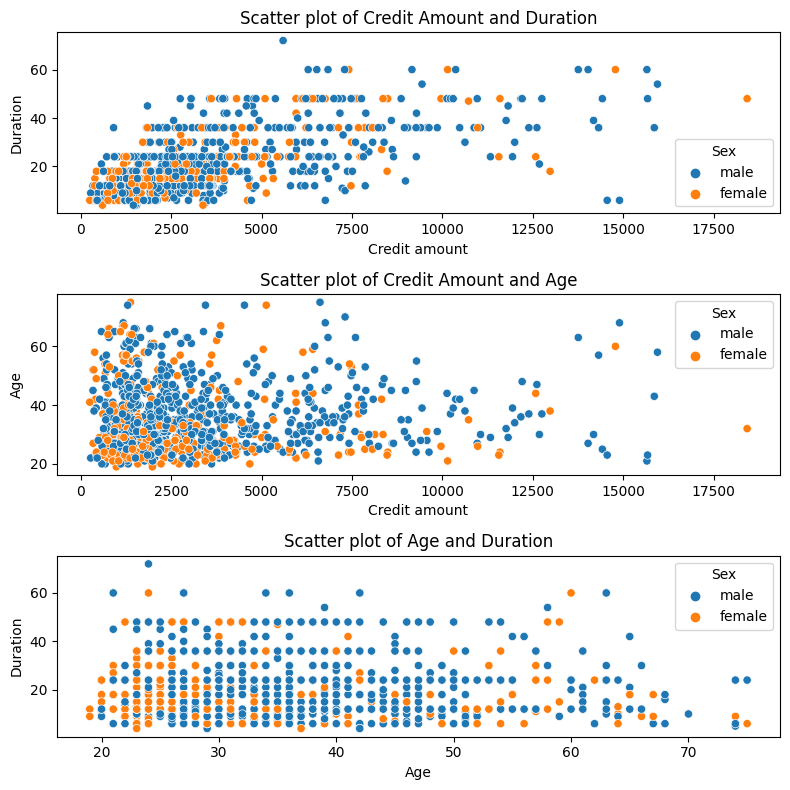

In [11]:
scatters(data, h="Sex")

From the top plot, there is `no clear difference` between `men and women` in terms of `amount and duration` of the credit. Also it seems that there is a `positive correlation between duration and amount of credit`. 

**Barplot of credits and purpose of loans**

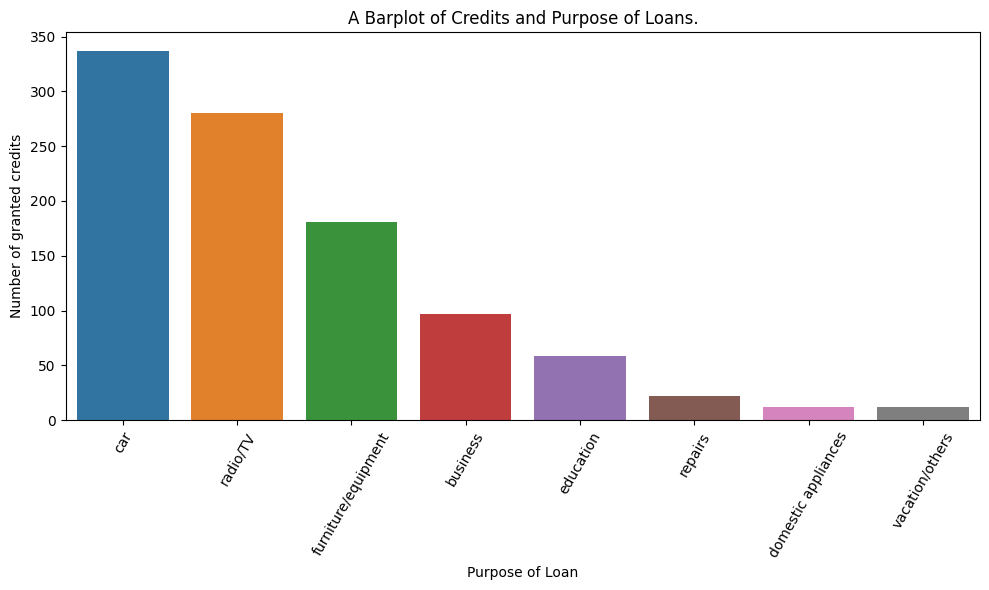

In [12]:
n_credits = data.groupby("Purpose")["Purpose"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.xlabel("Purpose of Loan")
plt.ylabel("Number of granted credits")
plt.title("A Barplot of Credits and Purpose of Loans.")
plt.tight_layout()

`Most` of the credits were granted on `car`, `radio/TV` and `furniture/equipment` loans, whiles `domestic appliances` and `vacations/others` were granted the `least` loans.

**Clustering with KMeans**

I will create a subset containing only numerical variables (Age, Credit amount, Duration). 

In [13]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
X = data.loc[:,selected_cols]

Lets create a function to look at the distribution of the variables.

In [14]:

def distributions(df):
    sns.displot(df["Age"])
    sns.displot(df["Credit amount"])
    sns.displot(df["Duration"])
    plt.tight_layout()

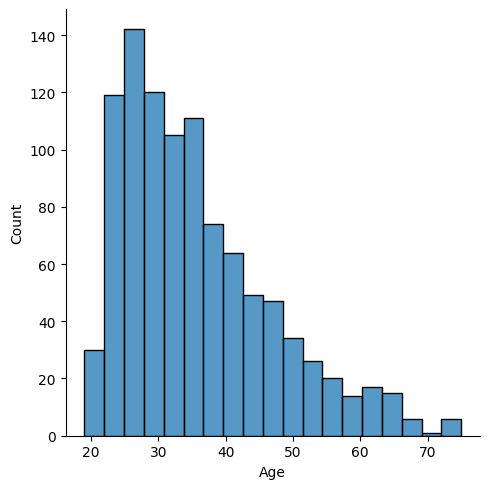

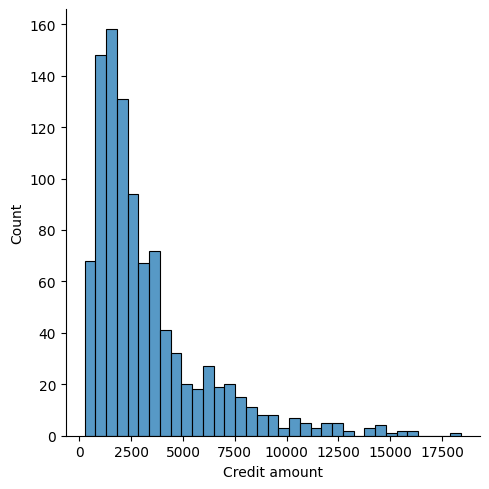

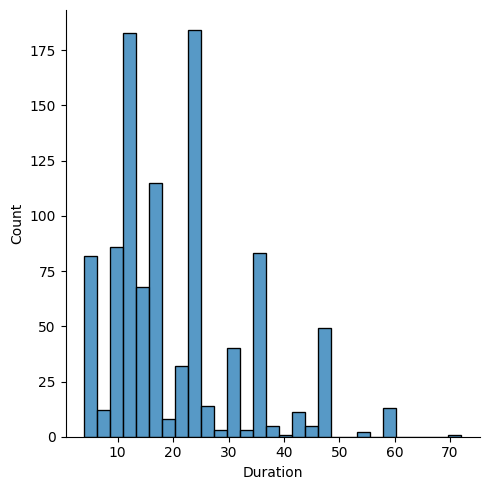

In [15]:
distributions(X)

The distributions are right-skewed. We will use logarithmic transformation to remove the skewness.

After lets look at our new distribution.

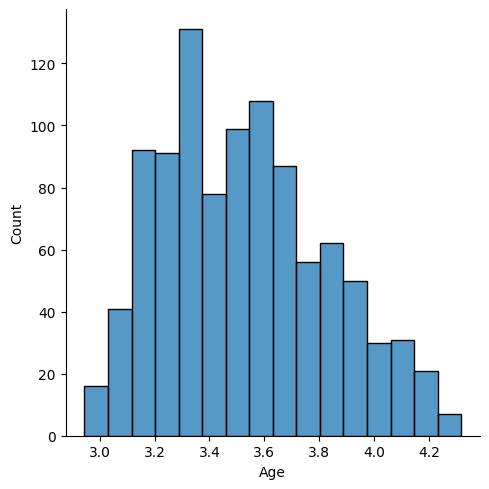

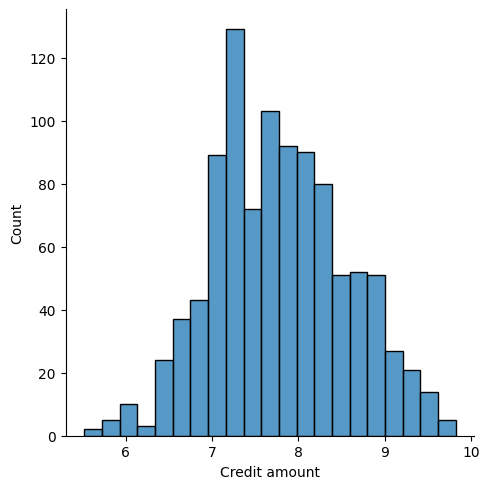

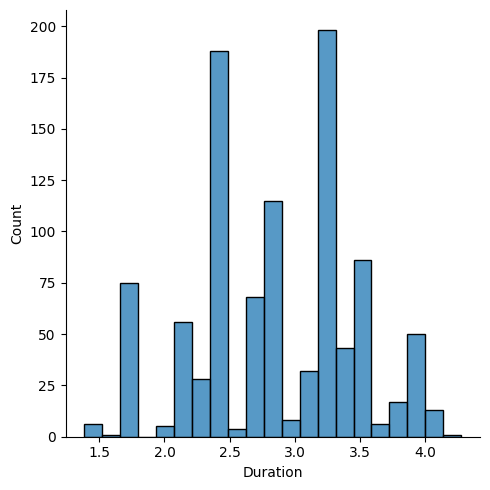

In [16]:
cluster_log = np.log(X)
distributions(cluster_log)

In [17]:
cluster_log.head()

,Age,Credit amount,Duration
0,4.204693,7.063904,1.791759
1,3.091042,8.691315,3.871201
2,3.891820,7.647786,2.484907
3,3.806662,8.972337,3.737670
4,3.970292,8.490849,3.178054


The skewness has been eliminated. 

## Model Building.



In [18]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(cluster_log)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (1000, 3)


,Age,Credit amount,Duration
0,2.271006,-0.933901,-1.864869
1,-1.446152,1.163046,1.708369
2,1.226696,-0.181559,-0.673790
3,0.942455,1.525148,1.478913
4,1.488620,0.904743,0.517289


In [19]:
n_clusters =range(2,13)
inertia_errors = []
silhouette_scores = []

#Add 'for' loop to train model and calculate inertia and silhouette score.
for k in n_clusters:
    #Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42,n_init="auto"))
    #Train model
    model.fit(cluster_log)
    # calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    #calculate silhouette score
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )
    
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [1908.8344540260287, 1437.6902293663695, 1199.8184206407368]

Silhouette Scores: [0.3962897602594097, 0.03226863151995826, 0.0286599439533405]


In [20]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters (k)", yaxis_title="Inertia")
fig.show()

You can see that the line starts to flatten out around 4 or 5 clusters.

In [21]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=silhouette_scores, 
    title="K-Means Model: Silhouette score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")

fig.show()

This one's a little less straightforward, but we can see that the best silhouette scores occur when there are 3 or 4 clusters.

Putting the information from this plot together with our inertia plot, it seems like the best setting for n_clusters will be 4.


## Final Model.

In [22]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4, random_state=42)
)
final_model.fit(cluster_log)

c:\Users\ENCHILL\OneDrive\Desktop\clustering\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [23]:
labels = final_model.named_steps["kmeans"].labels_
print(labels[:5])

[0 1 0 1 1]


In [24]:
clustered_data = X.assign(Cluster=labels)
clustered_data.head()

,Age,Credit amount,Duration,Cluster
0,67,1169,6,0
1,22,5951,48,1
2,49,2096,12,0
3,45,7882,42,1
4,53,4870,24,1


In [25]:
xgb=clustered_data.groupby(['Cluster']).mean().round(1)
xgb

,Age,Credit amount,Duration
Cluster,,,
0,50.2,2187.9,14.8
1,36.7,7092.8,36.8
2,28.6,2832.8,22.3
3,29.1,1351.0,10.5


In [26]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Variables by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Number")
fig.show()

First, let us take a look at the Credit amount column. You might think that it would scale as we move down the clusters, but it doesn't. The cluster with the lowest Credit amount is 3, whiles cluster 1 has the highest Credit amount. 

Age decreases as we go down the clusters, However cluster 3 has a slightly higher age than cluster 2.

Cluster 1 has the highest duration followed by cluster 2 and 1, whiles clsuter 3 has the lowest duration.


**Clusters,**

Cluster 0 – mid-range mean of credit amount, short duration, older customers

Cluster 1 – high mean of credit amount, long duration,early middle-aged customers

Cluster 2 - mid-range mean of credit amount, middle-time duration, young customers

Cluster 3 - low mean of credit amount, shortest duration, young customers

In [27]:
# Instantiate transformer
x = StandardScaler().fit_transform(cluster_log)
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(x)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (1000, 2)


,PC1,PC2
0,2.039569,2.263394
1,-2.068637,-1.418051
2,0.637681,1.234344
3,-2.098283,0.998277
4,-0.965198,1.532215


## PCA.

In [28]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels,
    title="PCA Representation of Clusters"
)

fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()